In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

In [2]:
from cfollmer.objectives import log_g, relative_entropy_control_cost
from cfollmer.sampler_utils import FollmerSDE

## Loading the StepFunc dataset

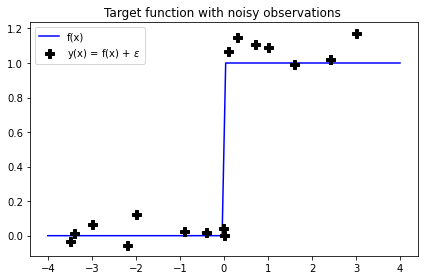

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"


# Test inputs
num_test_samples = 100
X_test = np.linspace(-4, 4, num_test_samples).reshape(num_test_samples,1)

# Noise free training inputs
X_train = np.array([-3.5, -3.4, -3,-2.2, -2, -0.9,-0.4, -0.01,0,0.1, 0.3,0.7, 1, 1.6 , 2.4, 3.0]).reshape(-1,1)
#f_train = np.cos(X_train) 
f_train = np.heaviside(X_train, 0)

# Noise-free training outputs
#f = np.cos(X_test)
f = np.heaviside(X_test, 0)
y_test  = f

# Noisy training Inputs with additive Gaussian noise (zero-mean, variance sigma_n)
sigma_n = 0.1

mu = np.zeros(X_train.size)
epsilon = np.random.multivariate_normal(mu, sigma_n**2 * np.eye(X_train.size))

# Noisy targets
y_train = f_train + epsilon.reshape(X_train.size,1)

# Noisy observations
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(X_test, f, 'b', label = 'f(x)')
ax.plot(X_train, y_train, 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

plt.show()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"



X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}


In [163]:
import torch.nn.functional as F


class OnedRegressionForwardNet(object):
    
    def __init__(self, input_dim=1, output_dim=1, depth=None, width_seq=None, device="cpu"):
        
        self.device = device
        self.output_dim = output_dim
        self.input_dim = input_dim 
        
        self.depth = depth
        if not self.depth:
            self.depth = 1
        if not width_seq:
            self.width = 20
            self.width_seq = [self.width] * (self.depth + 1)
            self.shapes = [(self.width_seq[i-1], self.width_seq[i])  for i in range(1,self.depth)]
            self.shapes += [(self.width_seq[-1], self.output_dim)]
            self.shapes = [(self.input_dim, self.width_seq[0])] + self.shapes
        
        self.dim = sum([wx * wy + wy for wx, wy in self.shapes])
        
    def forward(self, x, Θ):
        index = 0
        n, d = x.shape
#         dummy_col = torch.ones((n,1)).to(self.device)
#         x = torch.cat((x,dummy_col), dim=1)
        for wx, wy in self.shapes[:-1]:
            x = F.linear(
                x,
                Θ[index: index + wx * wy].reshape(wy, wx),
                Θ[index + wx * wy: index + wx * wy + wy].reshape(1,wy)
            )
            x = F.relu(x)
            index += wx * wy  + wy
        wx, wy = self.shapes[-1]
        x = F.linear(
            x,
            Θ[index: index + wx * wy].reshape(wy, wx),
            Θ[index + wx * wy: index + wx * wy + wy].reshape(1,wy)
        )
        return x.to(self.device)
    
    def map_forward(self, x, Θ):
        preds_func = lambda θ: self.forward(x, θ)
        batched_preds = torch._vmap_internals.vmap(preds_func)
        preds = torch.hstack(list(map(preds_func, Θ)))
        return preds
        

In [164]:
net = OnedRegressionForwardNet(1,1, device=device, depth=1)

def ln_prior(Θ, σ_w=1.0):
    """
    Logistic regresion bayesian prior
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w**2


def log_likelihood_vmap(Θ, X, y, net=net):
    """
    Hoping this implementation is less buggy / faster
    
    still feels a bit slow.
    """
    preds_func = lambda θ: net.forward(X, θ)
#     batched_preds = torch._vmap_internals.vmap(preds_func)
#     import pdb; pdb.set_trace()
    preds = torch.hstack(list(map(preds_func, Θ)))

    diff = preds - y
#     import pdb; pdb.set_trace()
    diff_sq_fld = -0.5 * (diff**2).sum(dim=0)

    return diff_sq_fld

In [165]:
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
dim = net.dim

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, net.dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [166]:
net.dim

61

In [167]:
relative_entropy_control_cost(sde, Θ_0, X_train, y_train, 
                              ln_prior, log_likelihood_vmap, γ=1.0, device=device)


tensor(424.0914, device='cuda:0', grad_fn=<MeanBackward0>)

In [168]:
γ = 1.0
Δt = 0.05
t_size = int(math.ceil(1.0/Δt))
ts = torch.linspace(0, 1, t_size).to(device)

sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.01, weight_decay =1)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 300
# with torch.autograd.set_detect_anomaly(True):
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer, torch.optim.LBFGS):
        def closure():
            loss = relative_entropy_control_cost(
                sde, Θ_0.float(),
                X_train.float(), y_train.float(),
                ln_prior, log_likelihood_vmap, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        losses.append(closure().item())
    else:
        loss = relative_entropy_control_cost(
            sde, Θ_0,
            X_train, y_train,
            ln_prior, log_likelihood_vmap, γ=γ
        )
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        losses.append(loss.item())

  0%|          | 0/300 [00:00<?, ?it/s]

In [169]:
X_train.shape

torch.Size([16, 1])

In [170]:
losses

[414.8651123046875,
 373.6449279785156,
 490.3372497558594,
 363.80853271484375,
 466.92578125,
 387.89483642578125,
 320.6294860839844,
 321.5435485839844,
 260.9314270019531,
 308.916015625,
 403.70428466796875,
 309.5963134765625,
 249.59530639648438,
 241.7292938232422,
 237.38351440429688,
 263.4765319824219,
 210.88616943359375,
 134.37464904785156,
 187.27066040039062,
 194.189208984375,
 161.8412628173828,
 169.93557739257812,
 152.66552734375,
 133.522216796875,
 131.6405792236328,
 165.0463104248047,
 109.53182983398438,
 157.95584106445312,
 157.87796020507812,
 110.36402893066406,
 133.49969482421875,
 154.3404083251953,
 122.81703186035156,
 139.1183624267578,
 126.21662902832031,
 135.73733520507812,
 123.40863037109375,
 131.3248748779297,
 144.99722290039062,
 130.4664764404297,
 122.33525085449219,
 141.0060272216797,
 124.85030364990234,
 147.8492889404297,
 121.97412872314453,
 161.21849060058594,
 132.66806030273438,
 128.859619140625,
 135.2775115966797,
 116.12960

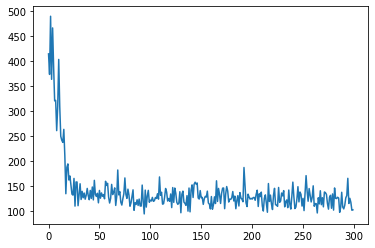

In [171]:
plt.plot(losses[:])

In [172]:
Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

(array([7., 3., 8., 6., 8., 8., 4., 4., 0., 2.]),
 array([-1.3482466 , -0.93788147, -0.5275163 , -0.11715119,  0.29321393,
         0.70357907,  1.1139442 ,  1.5243093 ,  1.9346745 ,  2.3450396 ,
         2.7554047 ], dtype=float32),
 <a list of 10 Patch objects>)

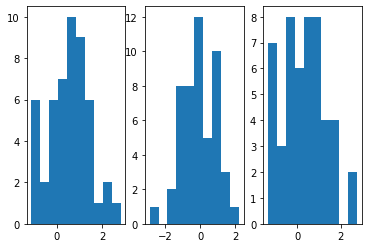

In [173]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.hist(Θ_1[:,0].cpu().detach().numpy())
ax2.hist(Θ_1[:,1].cpu().detach().numpy())
ax3.hist(Θ_1[:,2].cpu().detach().numpy())

In [174]:
pred = net.map_forward(X_train, Θ_1).mean(axis=1)

C:\Users\vargf\AppData\Local\Temp/ipykernel_25680/1419813516.py:47: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_preds = torch._vmap_internals.vmap(preds_func)


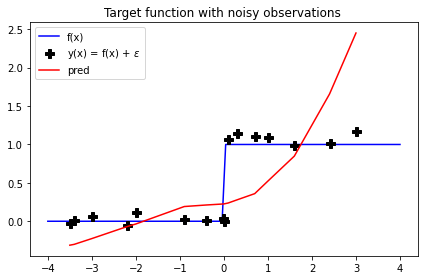

In [175]:


fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(X_test.detach().cpu(), f, 'b', label = 'f(x)')
ax.plot(X_train.detach().cpu(), y_train.detach().cpu(), 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
ax.plot(X_train.detach().cpu(), pred.detach().cpu(), color="red", label="pred")
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

plt.show()

In [149]:
net.dim

60

In [150]:
# net = OnedRegressionForwardNet(1,1, device=device, depth=3)
net.shapes

[(2, 20), (20, 1)]

tensor([ 0.8710, -1.0697,  1.2454], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.7849, -1.3721,  0.0225], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-8.6044e-04, -1.7010e+00,  7.6812e-01], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([ 0.2453, -3.7017, -1.0319], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.3904, -2.7703, -1.6476], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.3128, -1.0813,  0.0881], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.7360, -0.4741,  0.5866], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.8225, -1.1611, -0.8932], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.0647, -2.9682,  2.0634], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.3173, -2.9913, -0.7764], device='cuda:0', grad_fn=<SliceBackward0>)


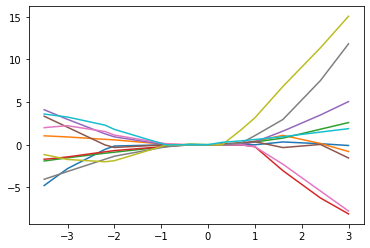

In [151]:
for i in range(10):
    print(Θ_1[i,:3])
    pred = net.forward(X_train, Θ_1[i,:,]).mean(axis=1)
    plt.plot(X_train.detach().cpu(), pred.detach().cpu())
# plt.plot(X_train.detach().cpu(), y_train.detach().cpu())

In [135]:
net_map = OnedRegressionForwardNet(1,1, device=device, depth=1)

Θ_map = torch.zeros((1, dim), requires_grad=True, device=device)
optimizer_map = torch.optim.Adam([Θ_map], lr=0.05)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)

losses_map = []
num_steps = 1000
for i in tqdm(range(num_steps)):
    optimizer_map.zero_grad()

    if isinstance(optimizer_map, torch.optim.LBFGS):
        def closure_map():
            loss_map = log_likelihood_vmap()
            optimizer_map.zero_grad()
            loss_map.backward()
            return loss

        optimizer_map.step(closure_map)
        losses_map.append(closure_map().item())
    else:
        loss_map = -(log_likelihood_vmap(Θ_map, X_train, y_train, net=net_map) + ln_prior(Θ_map))
        optimizer_map.zero_grad()
        loss_map.backward()

        optimizer_map.step()
        print(loss_map.item())
        losses_map.append(loss_map.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.16358375

4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.16358375

4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.163583755493164
4.16358375

In [131]:
pred = net_map.map_forward(X_train, Θ_map)

C:\Users\vargf\AppData\Local\Temp/ipykernel_25680/1106286376.py:39: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_preds = torch._vmap_internals.vmap(preds_func)


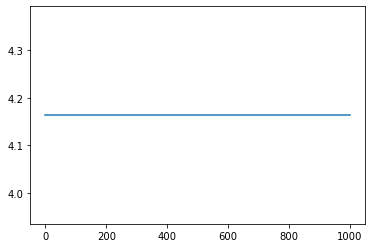

In [132]:
plt.plot(losses_map[:])

In [120]:
pred

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<CatBackward0>)

In [124]:
loss_map

tensor([4.1636], device='cuda:0', grad_fn=<NegBackward0>)